# Lecture 4

# The story so far

* The proposed elimination procedure can be implemented using numerical rootfinding methods
* It can be difficult to work with high-order polymials in floating-point arithmetic
* Elimination may be unstable in floating-point arithmetic

> Can we tackle the system directly?

# Contents

* Newton's method in multiple variables
* Dealing with non-invertible systems
* Computational efficiency


# Newton in multiple variables

> Given $f: \mathbb{R}^{n} \rightarrow \mathbb{R}^{m}$ ($m$ equations in $n$ unknowns), how do we find a root?


Newton's method in multiple variables reads

$$x_{k+1} = x_k - Df(x_k)^{-1}f(x_k),$$

with $Df : \mathbb{R}^{n} \rightarrow \mathbb{R}^{m\times n}$ is the Jacobian of $f$. It has quadratic convergence when starting close to a root when $Df(x^*)$ is invertible; linear convergence otherwise.

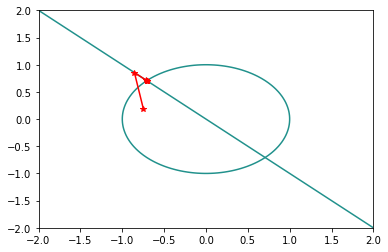

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# (x1^2 + x2^2 - 1), (x1 + x2), solutions 
f  = lambda x : np.array([x[0]**2 + x[1]**2 - 1, x[0]+x[1]])
Df = lambda x : np.array([[2*x[0], 2*x[1]],[1, 1]])

# Newton
niter = 10
X = np.zeros((niter,2))
X[0] = np.random.randn(2)
for k in range(niter-1):
    X[k+1] = X[k] - np.linalg.inv(Df(X[k]))@f(X[k])
    
# plot
x1,x2 = np.meshgrid(np.linspace(-2,2,100),np.linspace(-2,2,100))
plt.plot(X[:,0],X[:,1],'r-*')
plt.contour(x1,x2,x1**2 + x2**2 - 1,0)
plt.contour(x1,x2,x1+x2,0)
plt.xlim([-2,2])
plt.ylim([-2,2])

#
plt.savefig('./figures/fig21.png',dpi=300)

![](./figures/fig21.png)

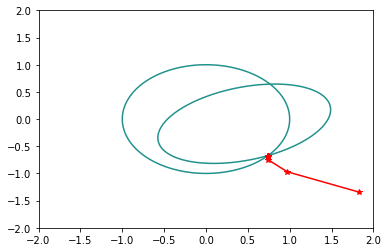

In [4]:
# (x1^2 + x2^2 - 1), (x1 + x2), solutions 
f  = lambda x : np.array([x[0]**2 + x[1]**2 - 1, (x[0]-.5)**2 + 2*(x[1] + .2)**2 - x[0]*x[1]-1])
Df = lambda x : np.array([[2*x[0], 2*x[1]],[2*(x[0]-.5)-x[1], 4*(x[1] + .2)-x[0]]])

# Newton
niter = 20
X = np.zeros((niter,2))
X[0] = np.random.randn(2)
for k in range(niter-1):
    X[k+1] = X[k] - np.linalg.inv(Df(X[k]))@f(X[k])
    
# plot
x1,x2 = np.meshgrid(np.linspace(-2,2,100),np.linspace(-2,2,100))
plt.plot(X[:,0],X[:,1],'r-*')
plt.contour(x1,x2,x1**2 + x2**2 - 1,0)
plt.contour(x1,x2,(x1-.5)**2 + 2*(x2 + .2)**2 - x1*x2-1,0)
plt.xlim([-2,2])
plt.ylim([-2,2])

#
plt.savefig('./figures/fig22.png',dpi=300)

![](./figures/fig22.png)

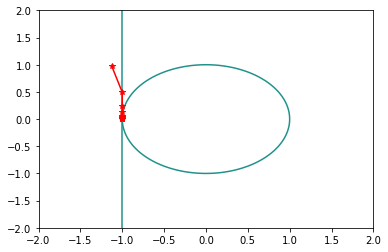

In [5]:
# (x1^2 + x2^2 - 1), (x1 + 1), solutions 
f  = lambda x : np.array([x[0]**2 + x[1]**2 - 1, x[0]+1])
Df = lambda x : np.array([[2*x[0], 2*x[1]],[1, 0]])

# Newton
niter = 10
X = np.zeros((niter,2))
X[0] = np.random.randn(2)
for k in range(niter-1):
    X[k+1] = X[k] - np.linalg.inv(Df(X[k]))@f(X[k])
    
# plot
x1,x2 = np.meshgrid(np.linspace(-2,2,100),np.linspace(-2,2,100))
plt.plot(X[:,0],X[:,1],'r-*')
plt.contour(x1,x2,x1**2 + x2**2 - 1,0)
plt.contour(x1,x2,x1+1,0)
plt.xlim([-2,2])
plt.ylim([-2,2])

#
plt.savefig('./figures/fig23.png',dpi=300)

![](./figures/fig23.png)

# Inverting a matrix

> How do we invert the Jacobian at each step?

* Gaussian elimination
* Iterative methods

## Richardson iteration for $Ax = b$

$$x_{k+1} = x_k + \alpha (b - Ax_k).$$

* convergence when $\|I - \alpha A\| < 1$
* how about indefinite matrices?

We are in fact approximating the solution via a Neumann series (for $x_0 = 0$, $\alpha = 1$)

$$x_n = \sum_{k=0}^{n-1}(I-A)^kb = P_{n-1}(A)b.$$

Can we find a better polynomial approximation?

* Ideally, we want a polynomial such that $P_{n}(\lambda_i) = \lambda_i^{-1}$ for all eigenvalues $\{\lambda_i\}_{i=1}^n$ of $A$.

* Equivalently, we want to find $Q_n(A) = AP_{n}(A) - I$ which as roots at $\{\lambda_i\}_{i=1}^n$.

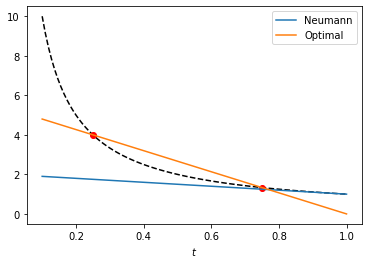

<Figure size 432x288 with 0 Axes>

In [7]:
A = np.array([[.5,.25],[.25,.5]])

l = np.linalg.eigvals(A)

t = np.linspace(.1,1,100)

p1 = lambda t : 1 + (1-t) #+ (1-t)**2 + (1-t)**3
p2 = lambda t : (1-t)/(.25*.75)

plt.plot(t,1/t,'k--')
plt.plot(l[0],1/l[0],'ro',l[1],1/l[1],'ro')
plt.plot(t,p1(t),label='Neumann')
plt.plot(t,p2(t),label='Optimal')
plt.xlabel(r'$t$')
plt.legend()
plt.show()

#
#
plt.savefig('./figures/fig24.png',dpi=300)

![](./figures/fig24.png)

## Krylov methods

The Richardson iteration generates a solution in the Krylov subspace

$$K_n(A,b) = \text{span}\{b, Ab, A^2b, \ldots, A^{n-1}b\}.$$

Can we find a better solution in this space?

Solve

$$\min_{x\in K_n(A,b)} \|Ax - b\|_2^2.$$

* form orthogonal basis for $K_n$
* compute minimum-residual solution
* update basis and repeat

In [34]:
from scipy.sparse.linalg import gmres

N = [20, 40, 60, 80, 100]
residual = []
error = []

for n in N:
    A = np.eye(n) - np.tril(np.ones((n,n)),-1)
    A[:,-1] = 1
    x = np.ones(n)
    b = A@x
    xh,_ = gmres(A, b, tol=1e-6)
    residual.append(np.linalg.norm(A@xh - b)/np.linalg.norm(b))
    error.append(np.linalg.norm(x - xh)/np.linalg.norm(x))
   
print('N   | Residual | Error    |')
print('-- -|----------|----------|')
for i in range(len(N)):
    print('%3d | %1.2e | %1.2e |'%(N[i], residual[i], error[i]))

N   | Residual | Error    |
-- -|----------|----------|
 20 | 1.80e-07 | 1.12e-06 |
 40 | 4.27e-07 | 5.53e-06 |
 60 | 7.67e-07 | 1.37e-05 |
 80 | 9.70e-07 | 2.20e-05 |
100 | 9.53e-07 | 2.70e-05 |


N   | Residual | Error    |
---|----------|----------|
 20 | 1.80e-07 | 1.12e-06 |
 40 | 4.27e-07 | 5.53e-06 |
 60 | 7.67e-07 | 1.37e-05 |
 80 | 9.70e-07 | 2.20e-05 |
100 | 9.53e-07 | 2.70e-05 |

# Dealing with non-invertible systems

> What to do when we have more / less equations than unknowns?

## The pseudo-inverse

The Moore-Penrose pseudo-inverse of a matrix $A$ is the unique matrix $A^\dagger$ satisfying:

1. $AA^\dagger A = A$
2. $A^\dagger A A^\dagger = A^\dagger$
3. $AA^\dagger$ is Hermitian
4. $A^\dagger A$ is Hermitian

Two special cases:

* $A^\dagger = (A^*\!A)^{-1}A^*$ when $A^*\!A$ is invertible (left inverse)
* $A^\dagger = A^*(A\!A^*)^{-1}$ when $A\!A^*$ is invertible (right inverse)



We can define the pseudo-inverse generally through the singular value decomposition:

$$A = U\Sigma V^*,$$

$$A^\dagger = V_k \Sigma_k^{-1} U_k^*,$$

with $k$ the rank of $A$.

## Iterative methods

How do we compute the minimum-norm solution of

$$\min_x \|Ax - b\|_2^2.$$

* Use Krylov (again)

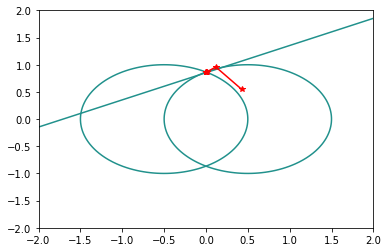

In [9]:
# overdetermined
# x1^2 + x2^2 = 1

f  = lambda x : np.array([(x[0]-.5)**2 + x[1]**2 - 1, (x[0]+.5)**2 + x[1]**2 - 1, x[0] - 2*x[1]+1+np.sqrt(2)/2])
Df = lambda x : np.array([[2*(x[0]-0.5), 2*x[1]],[2*(x[0]+0.5), 2*x[1]],[1,-2]])

# Newton
niter = 10
X = np.zeros((niter,2))
X[0] = np.random.randn(2)
for k in range(niter-1):
    X[k+1] = X[k] - np.linalg.pinv(Df(X[k]))@f(X[k])
    
# plot
x1,x2 = np.meshgrid(np.linspace(-2,2,100),np.linspace(-2,2,100))
plt.plot(X[:,0],X[:,1],'r-*')
plt.contour(x1,x2,(x1-.5)**2 + x2**2 - 1,0)
plt.contour(x1,x2,(x1+.5)**2 + x2**2 - 1,0)
plt.contour(x1,x2,x1-2*x2+1+np.sqrt(2)/2,0)
plt.xlim([-2,2])
plt.ylim([-2,2])

#
plt.savefig('./figures/fig25.png',dpi=300)

![](./figures/fig25.png)

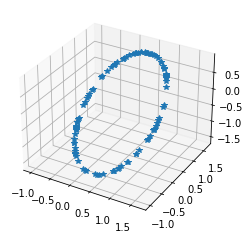

In [10]:
# underdetermined
# x1^2 + x2^2 + x3^2 - 3, x1 + x2 - x3 - 1; infintely many solutions

from mpl_toolkits.mplot3d import Axes3D

f  = lambda x : np.array([x[0]**2 + x[1]**2 + x[2]**2 - 3, x[0] + x[1] - x[2] - 1])
Df = lambda x : np.array([[2*x[0], 2*x[1], 2*x[2]],[1, 1, -1]])

# Newton
roots = np.zeros((100,3))
for i in range(100):
    niter = 10
    X = np.zeros((niter,3))
    X[0] = np.random.randn(3)
    for k in range(niter-1):
        X[k+1] = X[k] - np.linalg.pinv(Df(X[k]))@f(X[k])
    roots[i] = X[-1]
ax = plt.figure().add_subplot(projection='3d')
ax.plot(roots[:,0],roots[:,1],roots[:,2],'*')

plt.savefig('./figures/fig26.png',dpi=300)

![](./figures/fig26.png)

# Quasi-Newton methods

* it may be too computationally expensive to form and invert the Jacobian at each iteration
* the secant method  circumvents this in the scalar case by approximating $f'(x_k) \approx \frac{f(x_k) - f(x_{k-1})}{x_k - x_{k-1}}$
* can we generalise this to the multivariate case?

## The secant equation

The Jacobian satisfies 

$$Df(\xi_k)(x_{k} - x_{k-1}) = f(x_k) - f(x_{k-1}),$$

for $\xi_k$ an convex combination of $x_k, x_{k-1}$.

How do we get a usefull approximation $B_k$ or $H_k$ satisfying

$$H_k(x_{k} - x_{k-1}) = f(x_k) - f(x_{k-1}),$$

or

$$(x_{k} - x_{k-1}) = B_k(f(x_k) - f(x_{k-1})),$$


Assuming we have some $H_k$ (or $B_k$) satisfying the secant relation, how do we update it to obtain $H_{k+1}$ (or $B_{k+1}$)?

SR1-update:

$$H_{k+1} = H_k + \frac{(\Delta f_k - H_k\Delta x_k)(\Delta f_k - H_k\Delta x_k)^T}{(\Delta f_k - H_k\Delta x_k)^T\Delta x_k}$$

$$B_{k+1} = B_k + \frac{(\Delta x_k - B_k\Delta f_k)(\Delta x_k - B_k\Delta f_k)^T}{(\Delta x_k - B_k\Delta f_k)^T\Delta f_k}$$


# Some non-Newton methods

## Fixed point iteration

$$x_{k+1} = g(x_k),$$

with $g(x) = x - \alpha f(x)$.

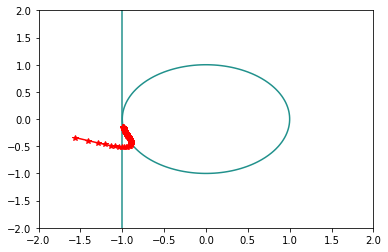

In [12]:
# (x1^2 + x2^2 - 1), (x1 + 1), solutions 
f  = lambda x : np.array([x[0]**2 + x[1]**2 - 1, x[0]+1])
Df = lambda x : np.array([[2*x[0], 2*x[1]],[1, 0]])
alpha = -.1

# fixed-point
niter = 100
X = np.zeros((niter,2))
X[0] = np.random.randn(2)
for k in range(niter-1):
    X[k+1] = X[k] - alpha*f(X[k])
    
# plot
x1,x2 = np.meshgrid(np.linspace(-2,2,100),np.linspace(-2,2,100))
plt.plot(X[:,0],X[:,1],'r-*')
plt.contour(x1,x2,x1**2 + x2**2 - 1,0)
plt.contour(x1,x2,x1+1,0)
plt.xlim([-2,2])
plt.ylim([-2,2])

#
plt.savefig('./figures/fig27.png',dpi=300)

![](./figures/fig27.png)

## Minimisation

$$\min_x \textstyle{\frac{1}{2}}\|f(x)\|_2^2.$$

which can be solved by 

$$x_{k+1} = x_k - \alpha Df(x_k)^*\cdot f(x_k)$$

* Need to pick $\alpha$ small enough
* Guaranteed to converge to *stationary point*

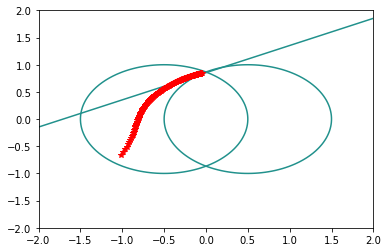

In [15]:
# overdetermined
# x1^2 + x2^2 = 1

f  = lambda x : np.array([(x[0]-.5)**2 + x[1]**2 - 1, (x[0]+.5)**2 + x[1]**2 - 1, x[0] - 2*x[1]+1+np.sqrt(2)/2])
Df = lambda x : np.array([[2*(x[0]-0.5), 2*x[1]],[2*(x[0]+0.5), 2*x[1]],[1,-2]])
alpha = 1e-2

# gradient-descent
niter = 200
X = np.zeros((niter,2))
X[0] = np.random.randn(2)
for k in range(niter-1):
    X[k+1] = X[k] - alpha*Df(X[k]).T@f(X[k])
    
# plot
x1,x2 = np.meshgrid(np.linspace(-2,2,100),np.linspace(-2,2,100))
plt.plot(X[:,0],X[:,1],'r-*')
plt.contour(x1,x2,(x1-.5)**2 + x2**2 - 1,0)
plt.contour(x1,x2,(x1+.5)**2 + x2**2 - 1,0)
plt.contour(x1,x2,x1-2*x2+1+np.sqrt(2)/2,0)
plt.xlim([-2,2])
plt.ylim([-2,2])

#
plt.savefig('./figures/fig28.png',dpi=300)

![](./figures/fig28.png)

# Summary

* Can solve system of non-linear equations with Newton's method
* Requires solution of linearised system at each iteration
* Alternatives exist which avoid this
* All these methods find *a* solution